# Get analysis efficiency

### June 12, 2020

## Code

### Import needed packages

In [2]:
import sys
sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd

### Get data from ROOT files

In [3]:
file_list=[]#Define an empty list
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/data/"):#Loop over desired directory
    if filename.endswith(".root"): #extension, .root in this case
        file_list.append(os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/allCuts/data/", str(filename))) #add file name to the list
        
        

In [4]:
chain = TChain("allCuts") #Define chain and tree that needs to be read. "allCuts" in this case.
for line in file_list:
    chain.AddFile(line)

In [5]:
corr_val = []
snr_val = []
failsRcut_V = []
failsRcut_H = []
# this_y_val = []
weight = []
energy = []
failsTopV = []
failsTopH = []
isSurface = []
# peakTheta_300m = []
# peakPhi_300m = []
for entry in chain:
#     if(entry.peakCorr_single[0]<0.01): continue
#     if(entry.peakPhi_single[0]<0):
#         phi.append(entry.peakPhi_single[0]+180) #extract variables of interest
#     else:
    corr_val.append(entry.corr_val[0]) 
    snr_val.append(entry.snr_val[0]) 
    failsRcut_V.append(entry.failsRcut[0])
    failsRcut_H.append(entry.failsRcut[1])
    failsTopV.append(entry.failsTopV)
    failsTopH.append(entry.failsTopH)
    isSurface.append(entry.isSurface)

    
#     this_y_val.append(entry.this_y_val[0])
    weight.append(entry.weight)
    energy.append(entry.energy)
#     peakTheta_300m.append(entry.peakTheta_300m[0]+90)
#     peakPhi_300m.append(entry.peakPhi_300m[0])

### Let's first bin up the energies

In [7]:
d = {'energy':np.array(energy), 'snr':np.array(snr_val), 'corr':np.array(corr_val), "failsCutV":np.array(failsRcut_V), "failsCutH":np.array(failsRcut_H), "failsTopV":failsTopV, "failsTopH":np.array(failsTopH), "isSurface":np.array(isSurface)}
cuts = pd.DataFrame(data=d)
cuts["failsCut"] = ((cuts.failsCutV==1) & (cuts.failsCutH==1))
cuts["failsTopCut"] = ((cuts.failsTopV==1) | (cuts.failsTopH==1))

cuts["passes"] = ((cuts.failsCut==False) & (cuts.failsTopCut==False) & (cuts.isSurface==False))
# cuts.energy.value_counts()
cuts.head()

,energy,snr,corr,failsCutV,failsCutH,failsTopV,failsTopH,isSurface,failsCut,failsTopCut,passes
0,3.459365e+19,36.247292,0.027403,0,0,0,0,0,False,False,True
1,1.922015e+16,6.897789,0.010513,0,1,0,0,0,False,False,True
2,1.836782e+18,12.622632,0.012572,0,1,1,0,0,False,True,False
3,2.743933e+16,4.209637,0.003144,1,1,0,0,1,True,False,False
4,2.423597e+18,10.712566,0.015349,0,1,0,0,1,False,False,False


In [29]:
forBins_half = np.logspace(15.5, 20.5, num=6)
forBins_half

array([3.16227766e+15, 3.16227766e+16, 3.16227766e+17, 3.16227766e+18,
       3.16227766e+19, 3.16227766e+20])

In [30]:
forBins = np.logspace(15, 20, num=6)
forBins

array([1.e+15, 1.e+16, 1.e+17, 1.e+18, 1.e+19, 1.e+20])

In [31]:
Ebins = np.concatenate([forBins_half,forBins])
Ebins = np.sort(Ebins)

In [32]:
cuts["binnedE"] = pd.cut(cuts.energy, bins=Ebins, labels=Ebins[1:]).astype(float)

In [33]:
cuts.head()

,energy,snr,corr,failsCutV,failsCutH,failsTopV,failsTopH,isSurface,failsCut,failsTopCut,passes,binnedE
0,5.724450e+17,5.266871,0.005361,1,1,1,1,1,True,True,False,1.000000e+18
1,7.536998e+16,5.756939,0.006587,1,1,0,0,0,True,False,False,1.000000e+17
2,1.427773e+18,8.434304,0.010894,0,1,0,1,1,False,True,False,3.162278e+18
3,1.754024e+18,10.980052,0.014154,0,1,0,0,1,False,False,False,3.162278e+18
4,2.848059e+18,40.007315,0.029302,0,0,0,0,0,False,False,True,3.162278e+18


In [34]:
total_num = cuts.binnedE.value_counts(sort=False)
total_num=total_num.sort_index()
forEff = pd.DataFrame(data = total_num)
forEff.index.name = 'Energy'
# forEff.index

In [35]:
passesCuts = cuts.loc[cuts.passes == True].binnedE.value_counts()
passesCuts = passesCuts.sort_index()
forEff["passesCuts"]=passesCuts
passesCuts

1.000000e+16      2
3.162278e+16     41
1.000000e+17    213
3.162278e+17    523
1.000000e+18    799
3.162278e+18    834
1.000000e+19    673
3.162278e+19    379
1.000000e+20    151
3.162278e+20     64
Name: binnedE, dtype: int64

In [36]:
forEff.passesCuts=forEff.passesCuts.fillna(0)
forEff.head()

,binnedE,passesCuts
Energy,,
3.162278e+15,28,0.0
1.000000e+16,76,2.0
3.162278e+16,259,41.0
1.000000e+17,863,213.0
3.162278e+17,1571,523.0


### Energies are binned up, let's calculate the efficiency

In [37]:
diffuseEff = pd.read_csv("./data/diffuse_eff.txt")
diffuseEff.head()

,energy,eff
0,11300000.0,0.0688
1,18200000.0,0.1100
2,28800000.0,0.1490
3,39600000.0,0.1820
4,60900000.0,0.2090


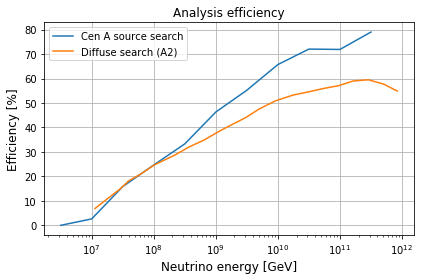

In [39]:
plt.plot(forEff.index/1E9, 100*forEff.passesCuts/forEff.binnedE, label = "Cen A source search")
plt.plot(diffuseEff.energy, 100*diffuseEff[" eff"], label = "Diffuse search (A2)")

plt.xscale('log')
plt.xlabel("Neutrino energy [GeV]", fontsize=12)
plt.ylabel("Efficiency [%]", fontsize=12)
plt.title("Analysis efficiency")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("./plots/CenA_search_efficiency.png", dpi=200)

#### Put cut line in the SNR vs $C_{sky}$ plot

In [9]:
m = -2080
y = np.linspace(0,1,50);
interc = 20.6-0.54
interc2 = 20.6

x = m*y+interc
x2 = m*y+interc2

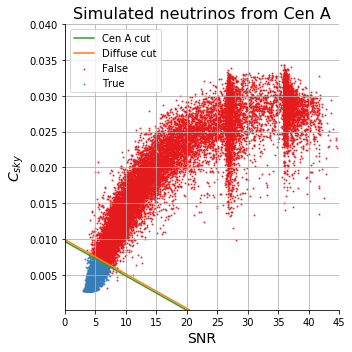

In [14]:
# sns.catplot(x="snr", y="corr", data=df2, hue='failsRcut');
sns.lmplot( x="snr", y="corr", data=cuts, fit_reg=False, hue='failsCut', legend=True, palette="Set1", legend_out=False, scatter_kws={"s": 1})
plt.plot(x,y, color="C2", label = "Cen A cut")
plt.plot(x2,y, color="C1", label = "Diffuse cut")


plt.xlabel("SNR", fontsize=14)
plt.ylabel("$C_{sky}$", fontsize=14)
# plt.xscale('log')
# plt.xscale('log')

plt.xlim(0,45)
plt.ylim(1e-4,0.04)
plt.grid()
plt.grid(which='minor', axis='both')
plt.title("Simulated neutrinos from Cen A", fontsize=16)
plt.legend()
plt.tight_layout()
# plt.savefig("./plots/SNRvsCsky_CenA.png", dpi=200)


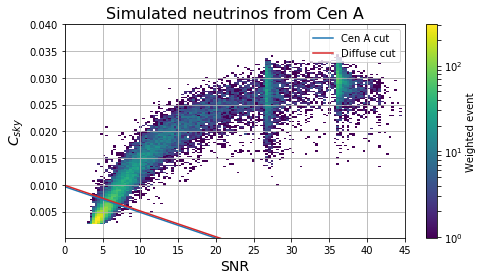

In [10]:
plt.figure(figsize=(7,4))
plt.hist2d(snr_val,corr_val, bins=120, weights=weight,norm=LogNorm());

# plt.hist2d(snr_val,corr_val, bins=420, weights=weight,norm=LogNorm());

plt.colorbar(label="Weighted event" )
plt.xlabel("SNR", fontsize=14)
plt.ylabel("$C_{sky}$", fontsize=14)
# plt.xscale('log')
# plt.xscale('log')
plt.plot(x,y, color="C0", label = "Cen A cut")
plt.plot(x2,y, color="C3", label = "Diffuse cut")

plt.xlim(0,45)
plt.ylim(1e-4,0.04)
plt.grid()
plt.grid(which='minor', axis='both')
plt.legend()
plt.title("Simulated neutrinos from Cen A", fontsize=16)
plt.tight_layout()
# plt.savefig("./plots/SNRvsCsky_CenADiffuse.png", dpi=200)

## Comments